# California Housing Challenge

The notebook is intended to predict the average house value upon the provided house features.

In [1]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.6-py3-none-any.whl size=143241 sha256=1f68dabdc2964cce0cb25aa956a974c13781d51eaa91ecc699cfc9fe38df9c90
  Stored in directory: /root/.cache/pip/wheels/15/b5/26/0fe17f6fc2cf206f657d177a68cebed422be876514f082187b
Successfully built databricks-cli
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [2]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import pprint

from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import mlflow

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import lightgbm as lgb

In [3]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = True

In [5]:
# Read training data
if kaggle:
    train_data = pd.read_csv('/kaggle/input/playground-series-s3e1/train.csv')
    test_data = pd.read_csv('/kaggle/input/playground-series-s3e1/test.csv')
else:
    train_data = pd.read_csv('./../../data/S3E1/california_housing_train.csv')
    test_data = pd.read_csv('./../../data/S3E1/california_housing_test.csv')

In [6]:
train_data.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


# Exploratory Data Analysis (EDA)

## Train Features & Label Distribution

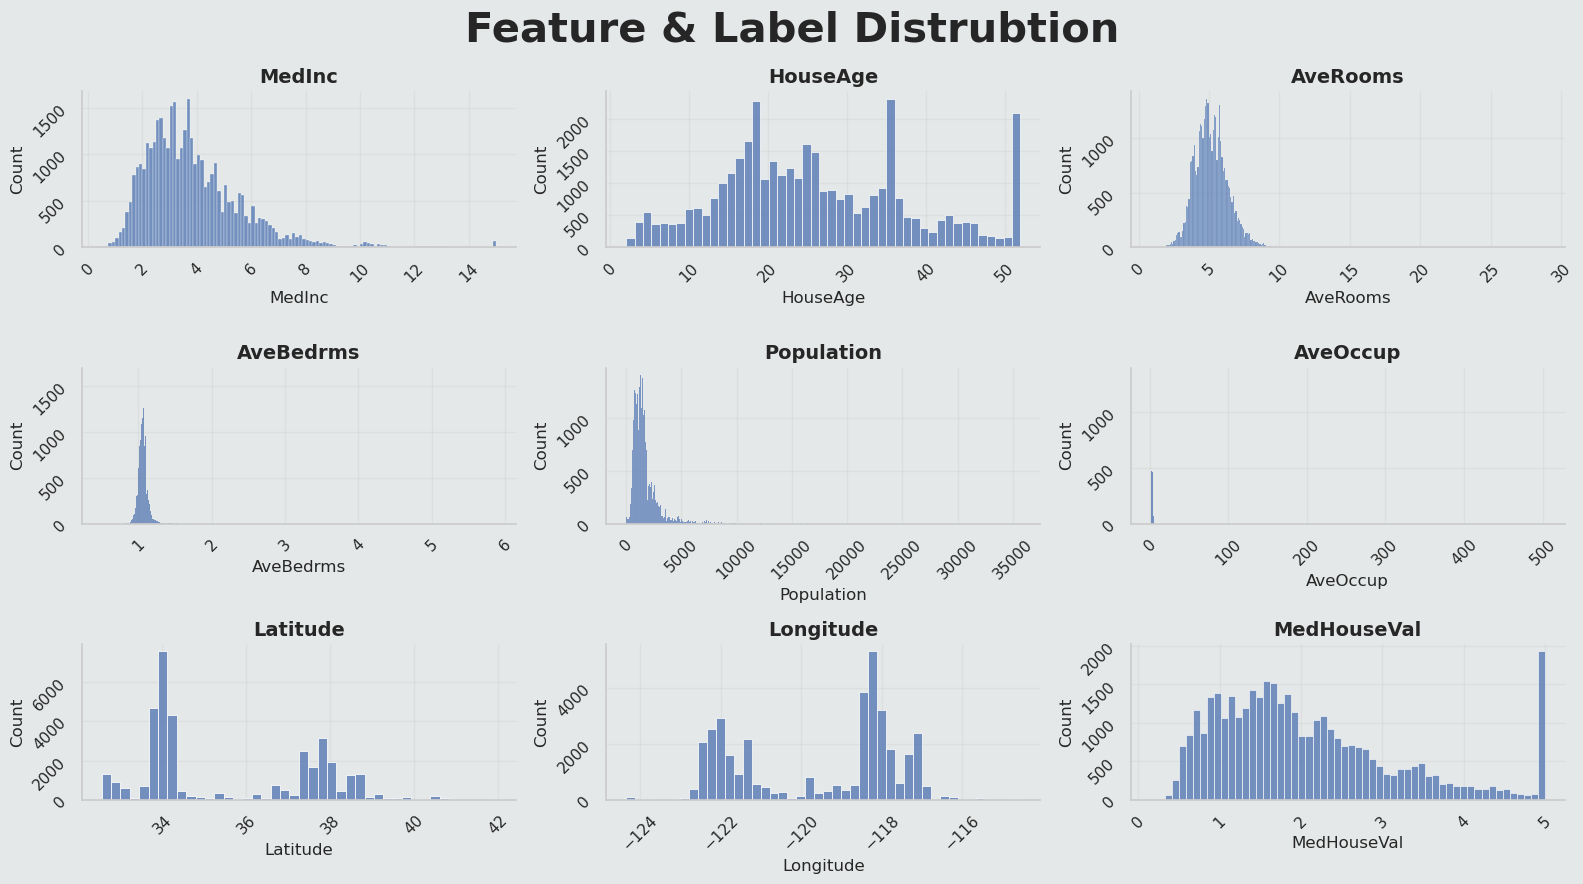

In [8]:
# Plot the histograms of each feature
figure, ax = plt.subplots(3, 3, figsize=(16, 9))
ax = ax.flatten()

# Fetch the data to plot (exclude the 'id' column)
for index, column_name in enumerate(train_data.columns[1:]):

    # Plot data
    sns.histplot(data=train_data[column_name], 
                 ax=ax[index])

    ax[index].set_title(column_name, 
                        fontsize=14, 
                        fontweight='bold')

    ax[index].tick_params(labelrotation=45)

plt.suptitle('Feature & Label Distrubtion', 
             fontweight='bold',
             fontsize=30)

plt.tight_layout()

### Average Occupancy Distribution

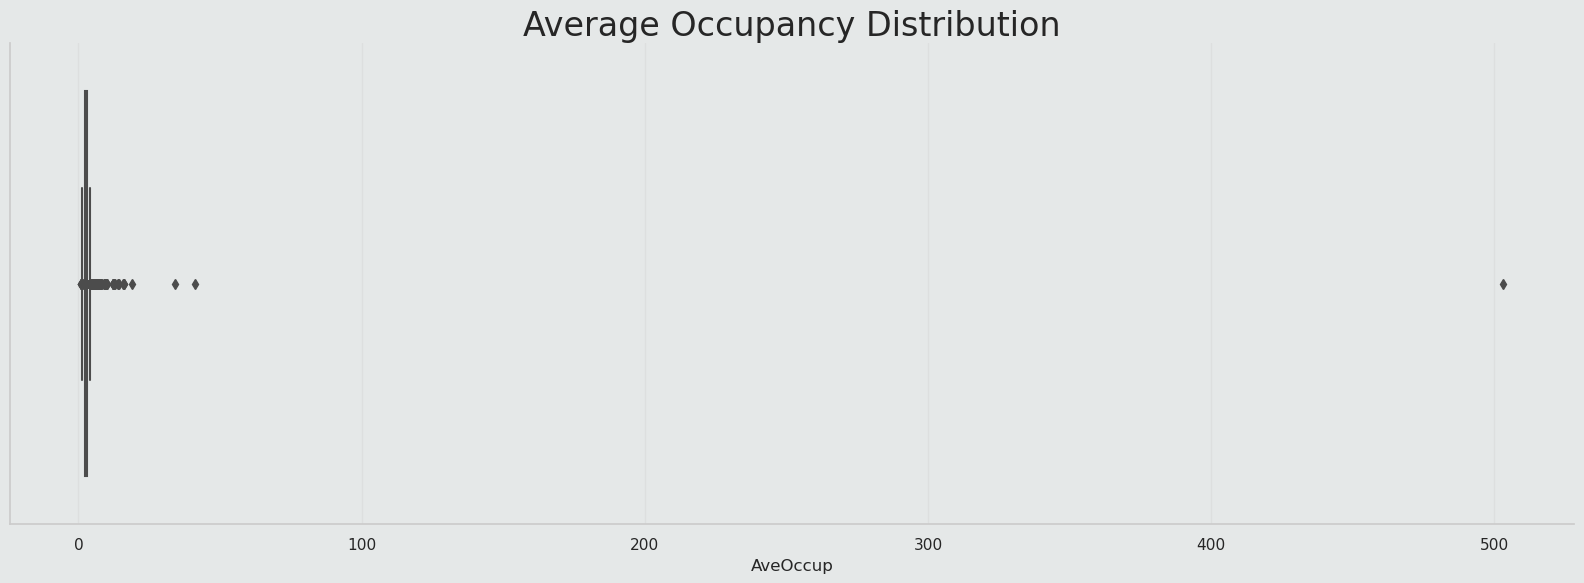

In [9]:
# Plot the histogram of 'AveOccup'
ax = sns.boxplot(data=train_data, 
                  x='AveOccup')


ax.set_title('Average Occupancy Distribution')

plt.tight_layout()

plt.show()

In [10]:
# Drop the outlier
train_data = train_data[train_data['AveOccup'] < 100].reset_index(drop=True)

- `HouseAge` has some strange peaks. Probably some rounding operations
- `AveOccup` has a huge outlier. It has been dropped for EDA sake.
- `MedHouseVal` has a strange peak at the end. Probably a cap

## Pearson Correlation

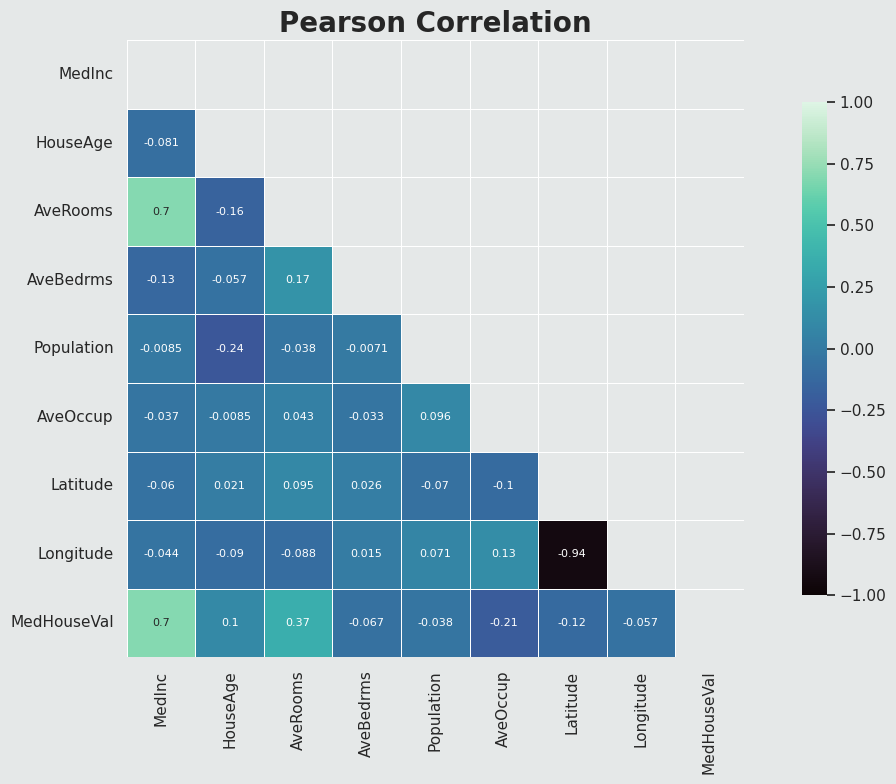

In [11]:
# Compute the correlation matrix
correlation_matrix = train_data.iloc[:, 1:].corr()

# Generate a mask for the upper triangle
correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Define figure and axis
figure, ax = plt.subplots(figsize=(12, 8))

# Plot the correlation matrix
sns.heatmap(correlation_matrix, 
            mask=correlation_mask, 
            cmap='mako',
            vmax=1.0, 
            vmin=-1.0, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            annot_kws={'fontsize': 8},
            cbar_kws={"shrink":.8, 'orientation':'vertical'})

# Set title
ax.set_title('Pearson Correlation', 
             fontsize=20, 
             fontweight='bold')

plt.tight_layout()

plt.show()

Positive correlation between:
- `AveRooms` and `MedInc`

## Train Data Geography

In [12]:
# Define dots colors
color_scale = [(0, 'orange'), (1,'red')]

# Plot the data
figure = px.scatter_mapbox(train_data,
                           lat="Latitude",
                           lon="Longitude",
                           hover_name="MedHouseVal",
                           hover_data=["MedHouseVal"],
                           color="MedHouseVal",
                           color_continuous_scale=color_scale,
                           size="MedHouseVal",
                           zoom=8,
                           height=600,
                           width=600)

figure.update_layout(mapbox_style="open-street-map")
figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
figure.show()

Define an `hot_area`flag for the houses sold in the following squares:
- (-123 <= lon <= -121.45) and (36.6 <= lat <= 38.6)
- (-119.90 <= lon <= -119.42) and (34.25 <= lat <= 34.5)
- (-119.35 <= lon <= -117.55) and (33.36 <= lat <= 34.52)
- (-117.29 <= lon <= -117.18) and (32.84 <= lat <= 33.01)

## Train vs Test Feature & Label Distribution

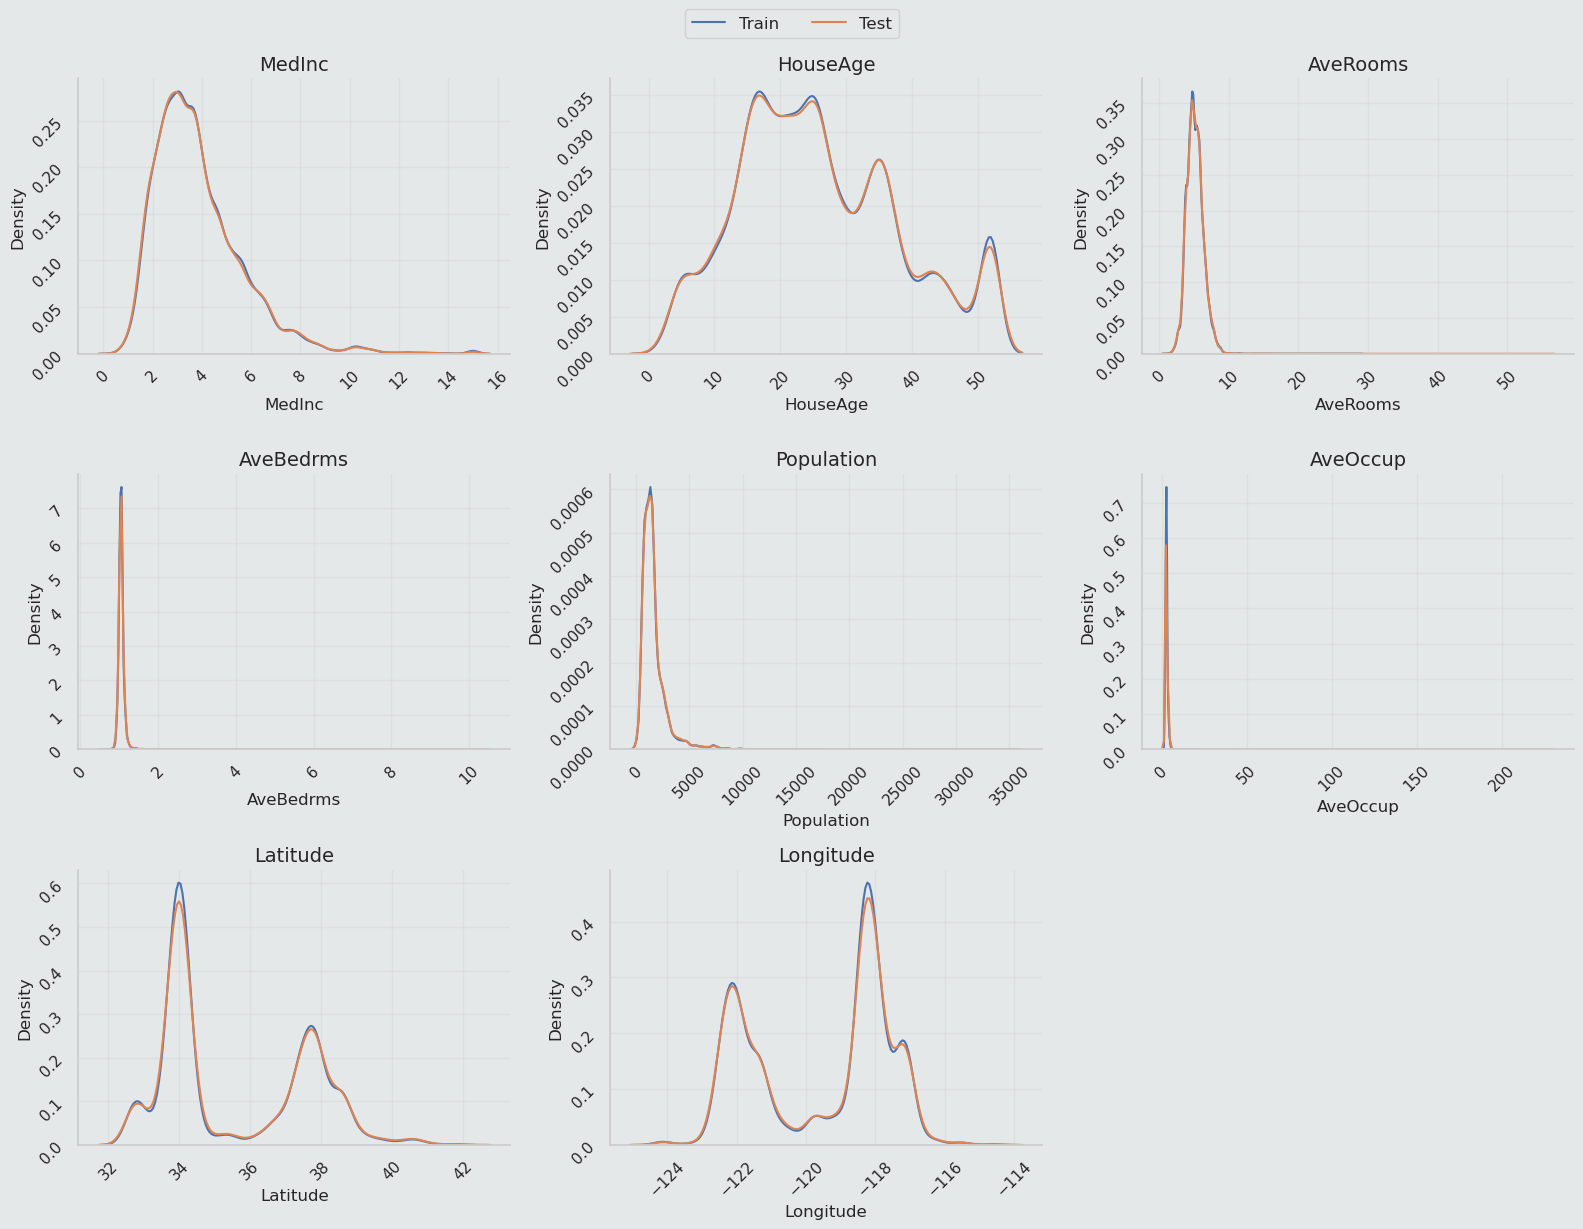

In [13]:
# Plot the KDE of each feature
figure, ax = plt.subplots(3, 3, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot (exclude the 'id' and 'quality' columns)
for index, column_name in enumerate(train_data.columns[1:-1]):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    ax[index].set_title(column_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplot
figure.delaxes(ax[-1])

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=2)

plt.tight_layout()

No difference in the train and test data distributions.

## Count Outliers with the Z-Score

In [14]:
# Compute the Z-Score for the feature columns across 'quality' classes
z_scores = train_data.iloc[:, 1:-1].apply(zscore)

In [15]:
# Consider as an 'outlier' every records with a Z-Score bigger than 2 SDs in absolute value terms
outliers = z_scores.abs().ge(2).sum().to_frame('Count').sort_values(by='Count')

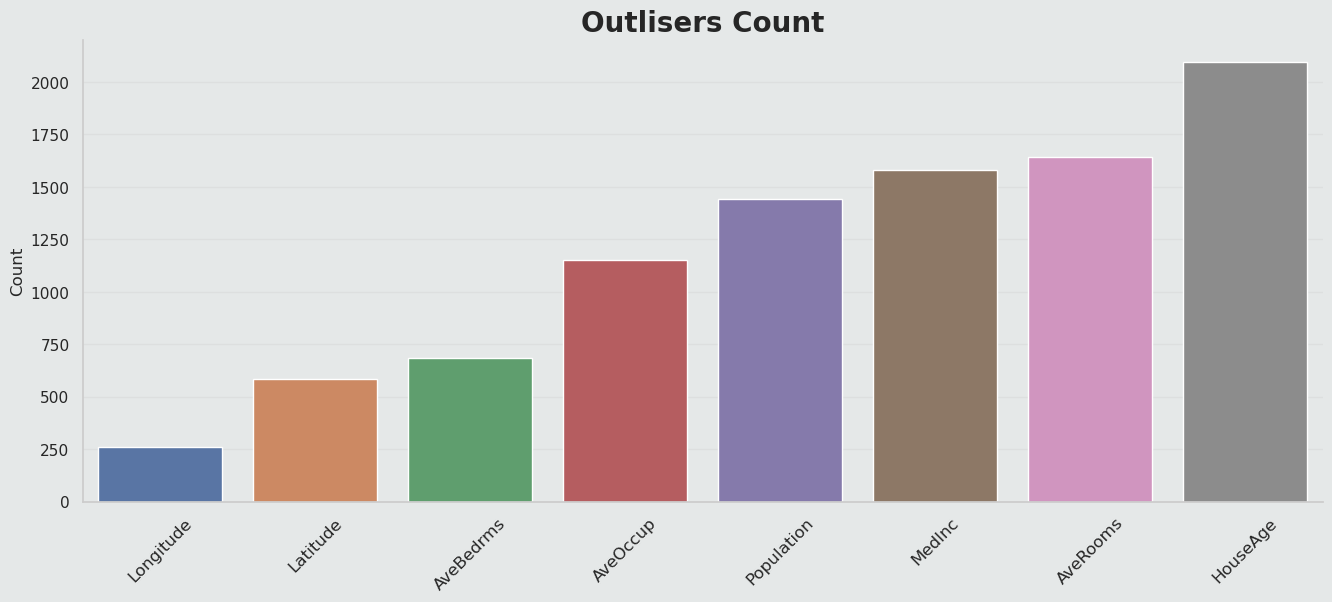

In [16]:
# Plot the feature importance
ax = sns.barplot(data=outliers, 
                 x=outliers.index.tolist(), 
                 y='Count')

# Set title
ax.set_title('Outlisers Count', 
             fontsize=20, 
             fontweight='bold')

plt.xticks(fontsize=12, 
           rotation=45)

plt.show()

The `HouseAge` has confirmed to have that strange spike at the end. It is necessary to create interval of classes for this feature.

## Train Features Pairplot

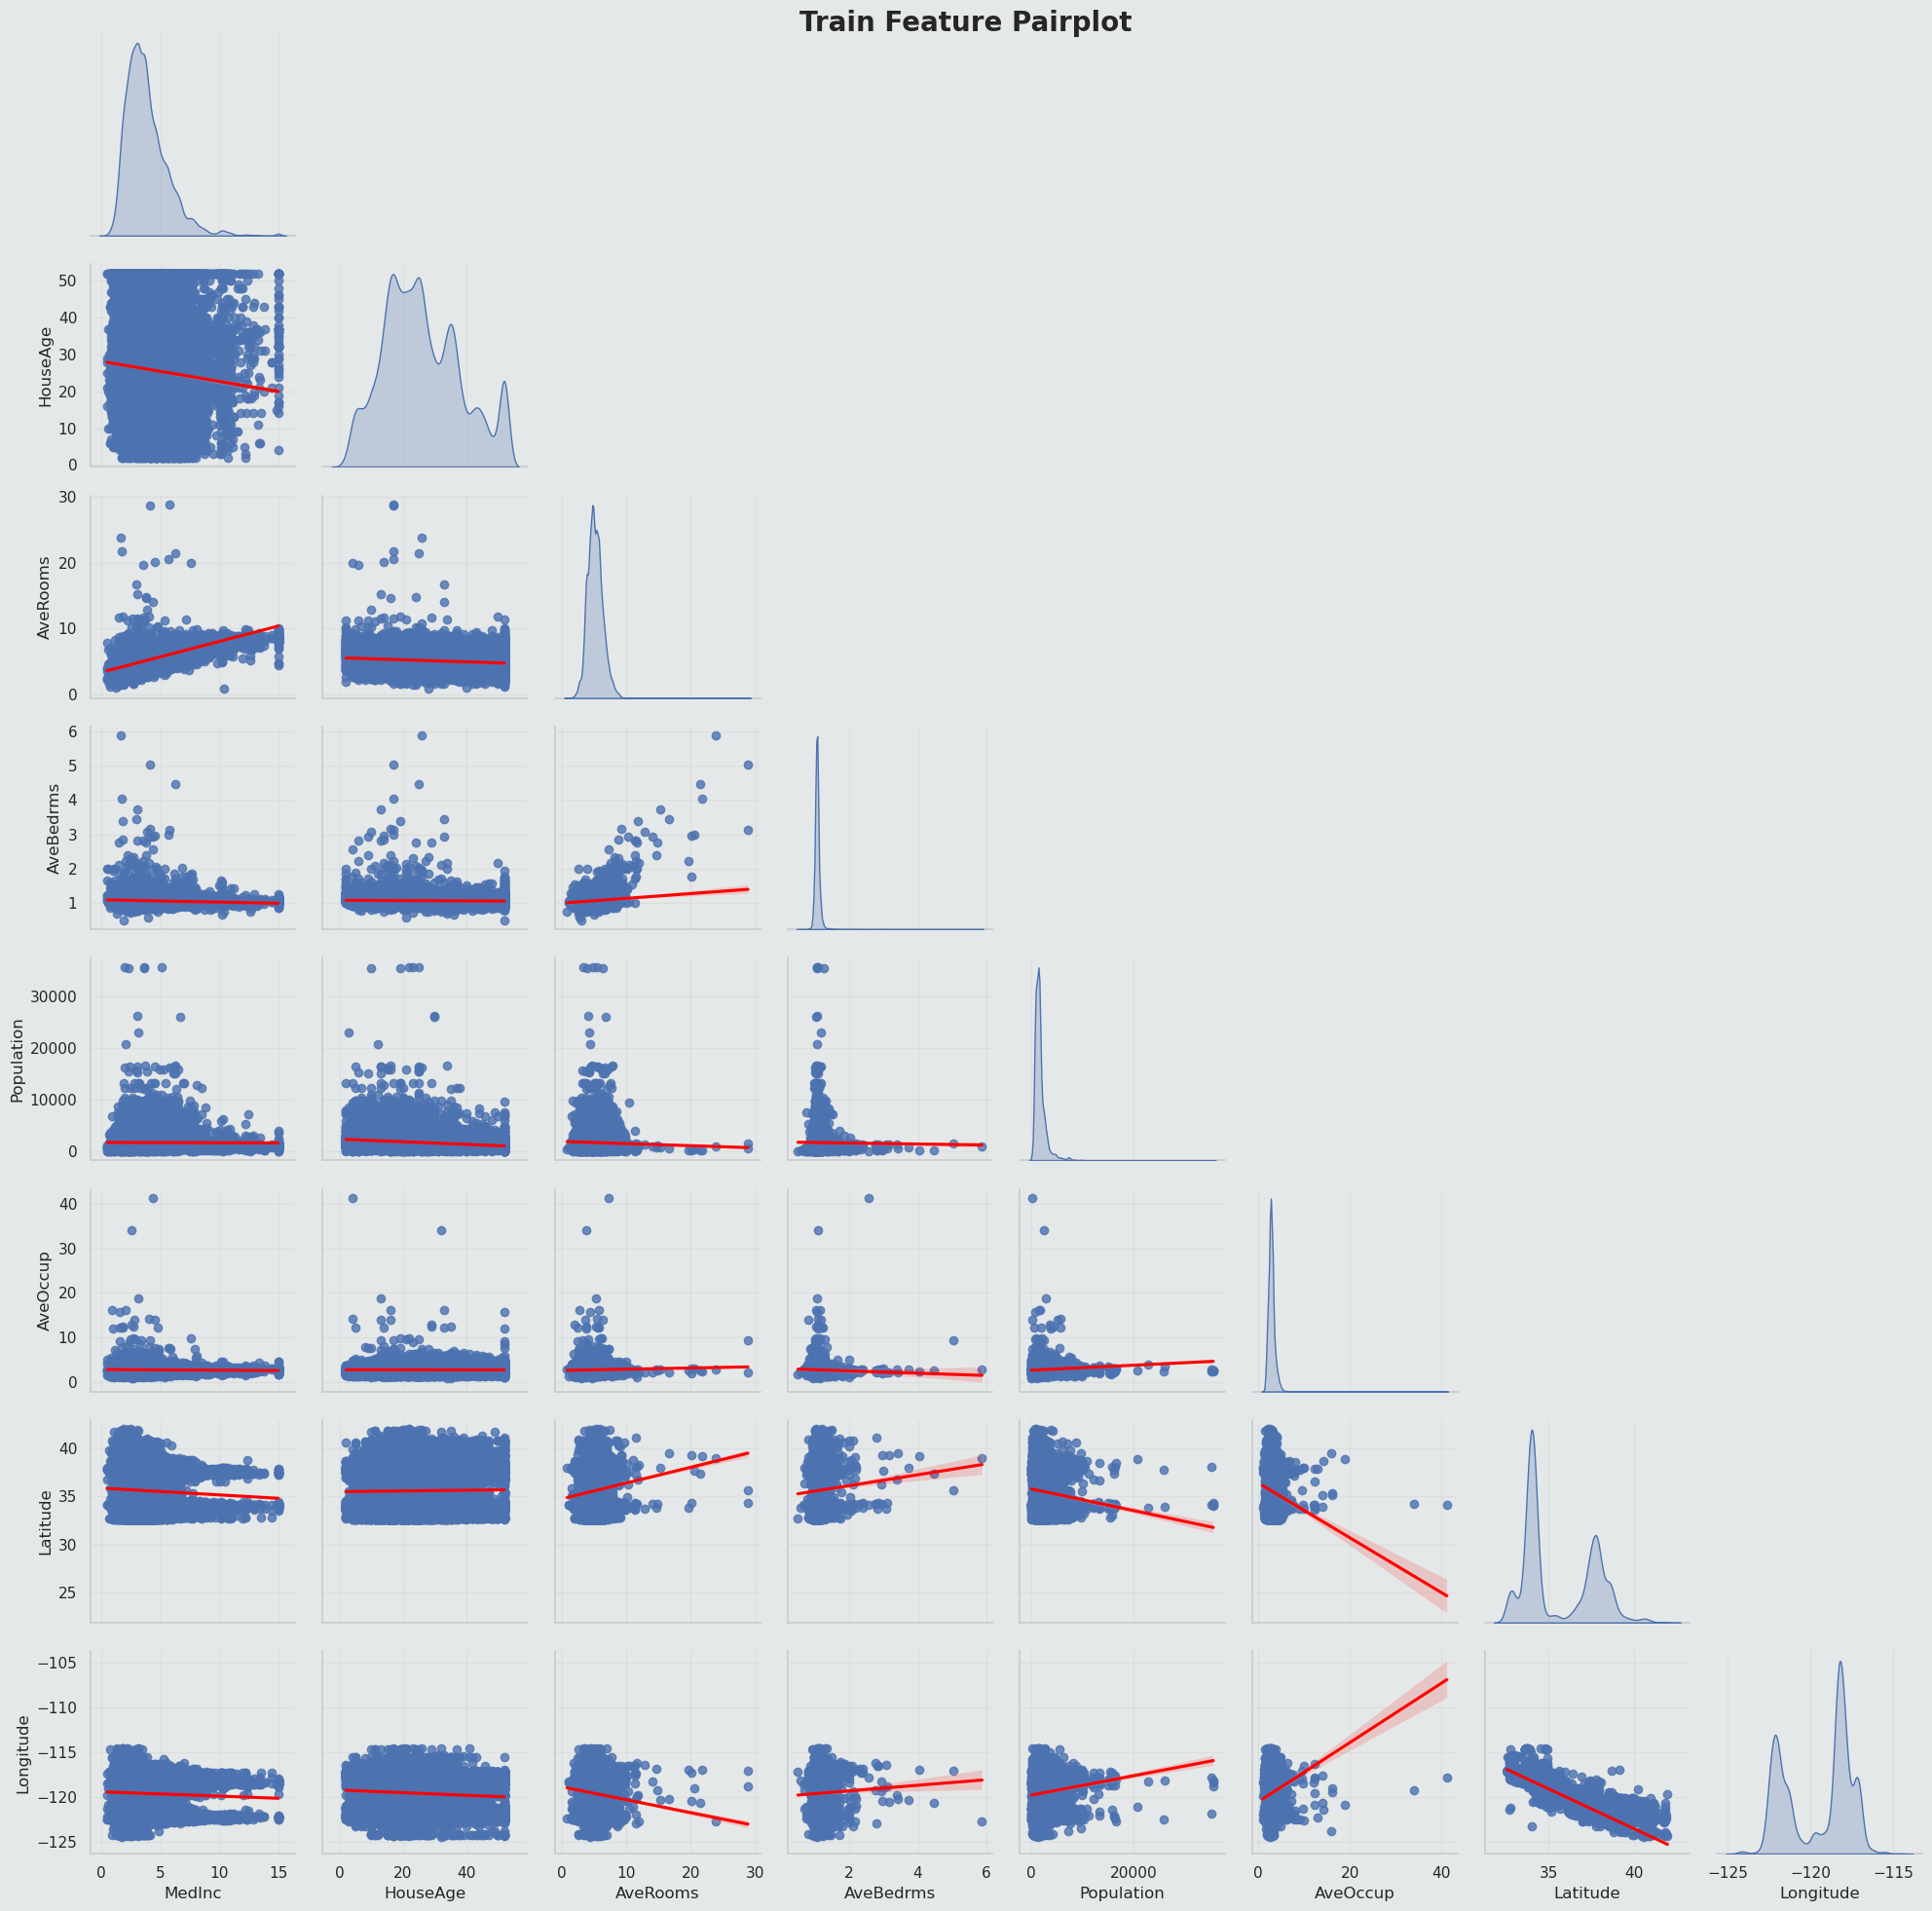

In [17]:
# Plot the Pairplot between the features
sns.pairplot(train_data.drop(columns=['id', 'MedHouseVal']),
             kind="reg",
             diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}},
             corner=True)

# Set title plot
plt.suptitle('Train Feature Pairplot', 
             fontsize=20, 
             fontweight='bold')

plt.tight_layout()

plt.show()

Positive correlations:
- `AveRooms` and `MedInc`
- `AveBedrms` and `AveRooms`

## Conclusions

- Round the HouseAge to 3 classes
- Create a feature `AveRooms per MedInc`
- Create a feature `HotArea`
- Create a feature `AveBedrms per AveRooms`

# Data Preparation

## Feature Engineering

In [18]:
def compute_engineered_features(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    
    Args:
        data Pandas.DataFrame input
    
    Returns:
        data Pandas.DataFrame with additional engineered features
    """
    
    # Define the conditions for the `HouseAgeClass` categories
    house_age_class_conditions = {
        1: data['HouseAge'] <= 17,
        2: (data['HouseAge'] > 17) &  (data['HouseAge'] < 52),
        3: data['HouseAge'] == 52
    }

    # Define a categorical variable called `HouseAgeClass`
    data['HouseAgeClass'] = np.select(house_age_class_conditions.values(),
                                      house_age_class_conditions.keys())
    
    
    # Create a feature `AveRooms per MedInc`
    data['AveRooms per MedInc'] = data['AveRooms'] * data['MedInc']
    
    # Create a feature `HotArea`
    # Define the rectangular areas of interest
    hot_areas = [(-123, -121.45, 36.6, 38.6),
                 (-119.90, -119.42, 34.25, 34.5),
                 (-119.35, -117.55, 33.86, 34.52),
                 (-117.29, -117.18, 32.84, 33.01)]

    # Check if each point is inside any of the hot areas
    is_in_hot_area = False
    for area in hot_areas:
        is_in_hot_area |= ((data['Longitude'] >= area[0]) &
                           (data['Longitude'] <= area[1]) &
                           (data['Latitude'] >= area[2]) &
                           (data['Latitude'] <= area[3]))
        
    # Assign a binary value to indicate if a point is in a hot area or not
    data['HotArea'] = np.where(is_in_hot_area, 1, 0)

    
    # Create a feature `AveBedrms per AveRooms`
    data['AveBedrms per AveRooms'] = data['AveBedrms'] * data['AveRooms']


In [19]:
# Apply the feature engineering
compute_engineered_features(train_data)
compute_engineered_features(test_data)

## Features and Labels Definition

In [20]:
# Define features and labels
numerical_features = train_data.columns[1:9].tolist()

numerical_engineered_featuers = ['AveRooms per MedInc', 
                                 'AveBedrms per AveRooms']

categorical_features = []

categorical_engineered_features = []
                                   #'HouseAgeClass',
                                   #'HotArea']

features = numerical_features + numerical_engineered_featuers + categorical_features + categorical_engineered_features

labels = ['MedHouseVal']

## Numerical Features Preprocessing Pipeline

In [21]:
# Numerical features pipeline
numerical_features_pipeline = Pipeline(steps=[
    ('numerical_scaler', StandardScaler()) # TODO: Add filtering outliers
])

## Bundle Data Preprocessing Steps

In [22]:
# Bunlde data preprocessing steps
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_preprocessing', 
         numerical_features_pipeline, 
         numerical_features + numerical_engineered_featuers),
        ('categorical_preprocessing', 
         'passthrough', 
         categorical_engineered_features)
    ])

# Train & Test Split

In [23]:
# Define X and y for the training set
X = train_data[numerical_features + numerical_engineered_featuers + categorical_engineered_features]
y = train_data[labels]

In [24]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model Training

In [25]:
# Set MLflow Experiment
mlflow_experiment_name = 'California Housing Price'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name)
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [26]:
# Define the used metrics
metrics = ['RMSE']

In [27]:
# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Linear Regression

In [28]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Linear Regression'):
    # Define the model
    model_lr = LinearRegression()

    # Define the pipeline
    pipe_lr = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('linear_regression', model_lr)
    ])

    # Train the pipeline
    pipe_lr.fit(X_train, 
                y_train)

    # Get predictions
    predictions_lr = pipe_lr.predict(X_test)

    # Compute metrics
    rmse_lr = round(mean_squared_error(y_test,
                                       predictions_lr), 2)

    print('RMSE: {}'.format(rmse_lr))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lr})
    
    # Log model's features
    mlflow.log_params({'Features': features})

RMSE: 0.53


CPU times: user 231 ms, sys: 96.8 ms, total: 328 ms
Wall time: 293 ms


In [29]:
# Update 'performance' DataFrame
performance.loc['Logistic Regression'] = [rmse_lr]

## Linear Regression - Cross-Validation

In [30]:
# Define the Cross-Validation Iterators
kfold = KFold(n_splits=4)
repeated_kfold = RepeatedKFold(n_splits=4, n_repeats=2, random_state=42)

In [31]:
def train_with_stratified_kfold(estimator, X, y, cv):
    """
    Train an Estimator through a Stratified K-Fold Cross-Validation approach and return evaluation metrics
    
        Paramarameters:
            estimator: sklearn.linear_model estimator to optimise
            X: Pandas DataFrame of data
            y: Pandas DataFrame of labels
            cv: sklearn.model_selection splitter instance
            
        Returns:
            rmse: Float RMSE
    """
    
    # Initialise empty lists for metrics
    rmse_list = []
    
    # Fetch the folds
    for fold, (train_index, validation_index) in enumerate(cv.split(X, y)):
        
        # Split the data
        X_train = X.loc[train_index]
        X_validation = X.loc[validation_index]
        y_train = y.loc[train_index]
        y_validation = y.loc[validation_index]
        
        # Fit the estimator
        estimator.fit(X_train, y_train)
        
        # Get predictions
        predictions = estimator.predict(X_validation)
        
        # Compute metrics
        rmse_fold = round(mean_squared_error(y_validation, predictions), 2)
        
        print('---- Fold {} ----'.format(fold))
        print('RMSE: {}'.format(rmse_fold))
        print('\n')
        
        # Append mentrics to the corresponding list
        rmse_list.append(rmse_fold)
        
    # Compute metrics average
    rmse = round(np.mean(rmse_list), 2)
        
    return rmse

### K-Fold

In [32]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Linear Regression K-Fold'):

    # Define the model
    model_lr_kfold = LinearRegression()

    # Define the pipeline
    pipe_lr_kfold = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('linear_regression', model_lr_kfold)
    ])

    # Train the pipeline with K-Fold
    rmse_lr_kfold = train_with_stratified_kfold(pipe_lr_kfold, X, y, kfold)

    print('RMSE: {}'.format(rmse_lr_kfold))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lr_kfold})
    
    # Log model's features
    mlflow.log_params({'Features': features})

    # Update 'performance' DataFrame
    performance.loc['Logistic Regression - K-Fold'] = [rmse_lr_kfold]

---- Fold 0 ----
RMSE: 0.49


---- Fold 1 ----
RMSE: 0.51


---- Fold 2 ----
RMSE: 0.5


---- Fold 3 ----
RMSE: 0.5


RMSE: 0.5


CPU times: user 431 ms, sys: 360 ms, total: 791 ms
Wall time: 232 ms


### Repeated K-Fold

In [33]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='Linear Regression Repeated K-Fold'):

    # Define the model
    model_lr_rkfold = LinearRegression()

    # Define the pipeline
    pipe_lr_rkfold = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('linear_regression', model_lr_rkfold)
    ])

    # Train the pipeline with K-Fold
    rmse_lr_rkfold = train_with_stratified_kfold(pipe_lr_rkfold, X, y, repeated_kfold)

    print('RMSE: {}'.format(rmse_lr_rkfold))
    print('\n')
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lr_rkfold})
    
    # Log model's features
    mlflow.log_params({'Features': features})

    # Update 'performance' DataFrame
    performance.loc['Logistic Regression - Repeated K-Fold'] = [rmse_lr_rkfold]

---- Fold 0 ----
RMSE: 0.52


---- Fold 1 ----
RMSE: 0.5


---- Fold 2 ----
RMSE: 0.49


---- Fold 3 ----
RMSE: 0.49


---- Fold 4 ----
RMSE: 0.5


---- Fold 5 ----
RMSE: 0.5


---- Fold 6 ----
RMSE: 0.52


---- Fold 7 ----
RMSE: 0.49


RMSE: 0.5


CPU times: user 956 ms, sys: 734 ms, total: 1.69 s
Wall time: 458 ms


## XGBoost

In [34]:
# XGBoost Hyperparameters
hyperparameter_xgb = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.01
}

In [35]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='XGBoost'):

    # Define the model
    model_xgb = XGBRegressor(**hyperparameter_xgb)

    # Define the pipeline
    pipe_xgb = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('xgboost', model_xgb)
    ])

    # Train the pipeline
    pipe_xgb.fit(X_train,
                 y_train,
                 xgboost__verbose=False)

    # Get predictions
    predictions_xgb = pipe_xgb.predict(X_test)

    # Compute metrics
    rmse_xgb = round(mean_squared_error(y_test, predictions_xgb), 2)
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_xgb})
    
    # Log model's features
    mlflow.log_params({'Features': features, 'Hyperparameters': hyperparameter_xgb})

    print('RMSE: {}'.format(rmse_xgb))
    print('\n')

RMSE: 0.36


CPU times: user 50.5 s, sys: 152 ms, total: 50.7 s
Wall time: 13 s


In [36]:
# Update 'performance' DataFrame
performance.loc['XGBoost'] = [rmse_xgb]

## LightGBM

In [37]:
# LightGBM hyperparameters
hyperparameters_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'force_row_wise': True,
    'n_estimators': 1000,
    'verbose': 0
}

In [38]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='LightGBM'):

    # Define the model
    model_lgb = lgb.LGBMRegressor(**hyperparameters_lgb)

    # Define the pipeline
    pipe_lgb = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('lightgbm', model_lgb)
    ])

    # Train the pipeline
    pipe_lgb.fit(X_train, 
                 np.ravel(y_train))

    # Get predictions
    predictions_lgb = pipe_lgb.predict(X_test)

    # Compute metrics
    rmse_lgb = round(mean_squared_error(y_test, predictions_lgb), 2)
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lgb})
    
    # Log model's features
    mlflow.log_params({'Features': features, 'Hyperparameters': hyperparameters_lgb})

    print('RMSE: {}'.format(rmse_lgb))
    print('\n')

RMSE: 0.34


CPU times: user 9.79 s, sys: 4.18 s, total: 14 s
Wall time: 7.94 s


In [39]:
# Update 'performance' DataFrame
performance.loc['LightGBM'] = [rmse_lgb]

## LightGBM with GridSearch

In [40]:
# LightGBM hyperparameters
hyperparameters_lgb_gs = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse'
}

# LightGBM hyperparameters space
hyperparameters_space_lgb_gs = {
    'lightgbm__num_leaves': np.arange(10, 60, 10),
    'lightgbm__learning_rate': np.linspace(0.001, 1, 5),
    'lightgbm__n_estimators': np.arange(50, 1000, 100)
}

In [41]:
%%time

# Start MLflow Run
with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                      run_name='LightGBM with GridSearch'):

    # Define the model
    model_lgb_gs = lgb.LGBMRegressor(**hyperparameters_lgb_gs)

    # Define the pipeline
    pipe_lgb_gs = Pipeline([
        ('data_preprocessing', data_preprocessor),
        ('lightgbm', model_lgb_gs)
    ])
    
    # Define GridSearch
    # NOTE: GridSearchCV tries to maximise its score, that's why we need the Negative RMSE
    grid_search_lgb_gs = GridSearchCV(estimator=pipe_lgb_gs, 
                                      param_grid=hyperparameters_space_lgb_gs, 
                                      cv=3, 
                                      n_jobs=2, 
                                      scoring='neg_root_mean_squared_error', 
                                      verbose=3)

    # Search the best hyperparameters
    grid_search_lgb_gs.fit(X_train, 
                           np.ravel(y_train))

    # Retrieve the best model
    best_model_lgb_gs = grid_search_lgb_gs.best_estimator_
    
    # Retrieve best model's parameters
    best_parameters_lgb_gs = best_model_lgb_gs['lightgbm'].get_params()
    
    print("Model's Best Hyperparameters:")
    pprint.pprint(best_parameters_lgb_gs)
    print('\n')
    
    # Get predictions
    predictions_lgb_gs = best_model_lgb_gs.predict(X_test)

    # Compute metrics
    rmse_lgb_gs = round(mean_squared_error(y_test, predictions_lgb_gs), 2)
    
    # Log model's evaluation metrics
    mlflow.log_metrics({'RMSE': rmse_lgb_gs})
    
    # Log model's features
    mlflow.log_params({'Features': features, 'Hyperparameters': best_parameters_lgb_gs})

    print('RMSE: {}'.format(rmse_lgb_gs))
    print('\n')

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV 2/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=10;, score=-1.114 total time=   0.4s
[CV 1/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=20;, score=-1.136 total time=   0.5s
[CV 3/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=20;, score=-1.122 total time=   0.5s
[CV 2/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=30;, score=-1.110 total time=   0.6s
[CV 1/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=40;, score=-1.134 total time=   0.7s
[CV 3/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=40;, score=-1.120 total time=   0.7s
[CV 2/3] END lightgbm__learning_rate=0.001, lightgbm__n_estimators=50, lightgbm__num_leaves=50;, score=-1.109 total time=   0.8s
[CV 1/3] END lightgbm__learning_ra

In [42]:
# Update 'performance' DataFrame
performance.loc['LightGBM GirdSearch'] = [rmse_lgb_gs]

# Models Comparison

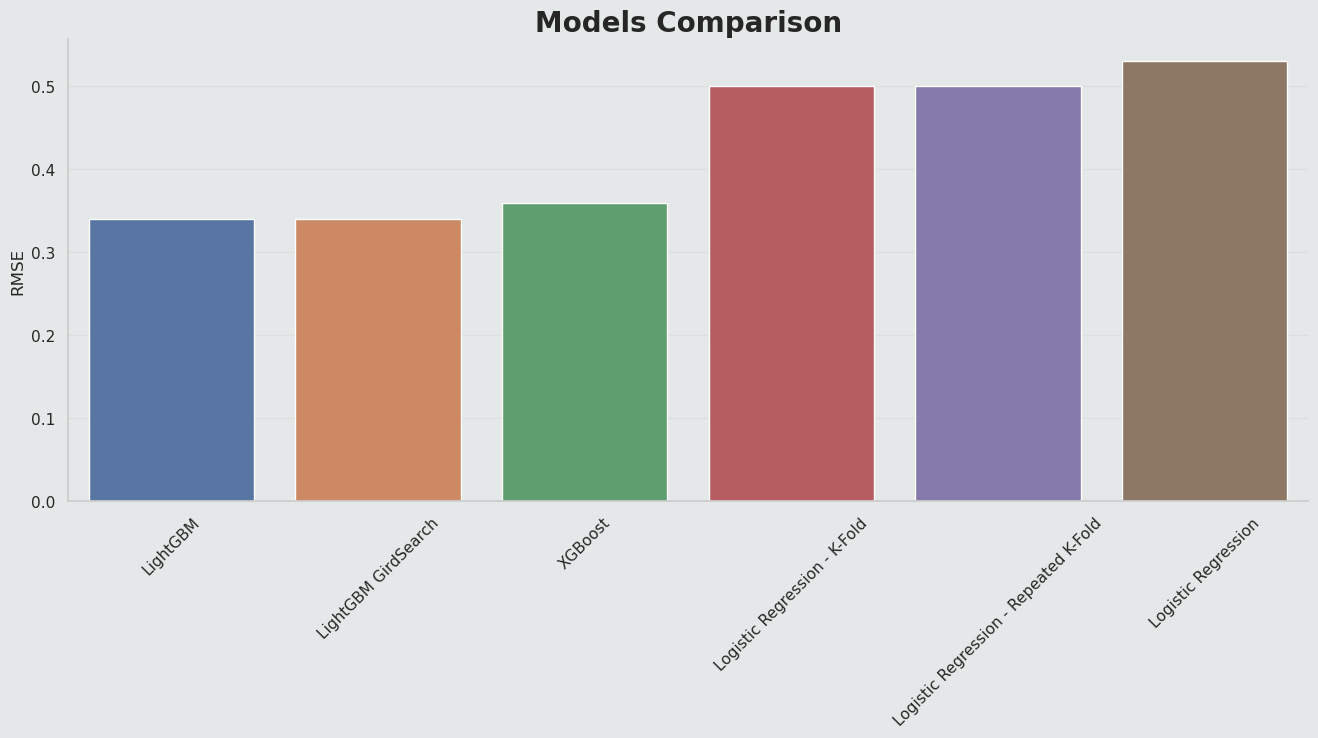

In [43]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x=performance.index.tolist(), 
                 y='RMSE')

# Set title
ax.set_title('Models Comparison', 
             fontsize=20, 
             fontweight='bold')

plt.xticks(rotation=45)

plt.show()

# Model Explanability

In [44]:
# Compute the feature importance
feature_importance = sorted(list(zip(pipe_lgb.feature_names_in_,
                                     pipe_lgb['lightgbm'].feature_importances_)),
                            key=lambda x: x[1], reverse=True)

# Transform it into a DataFrame
feature_importance_df = pd.DataFrame(feature_importance,
                                     columns= ['Feature', 'Importance'])

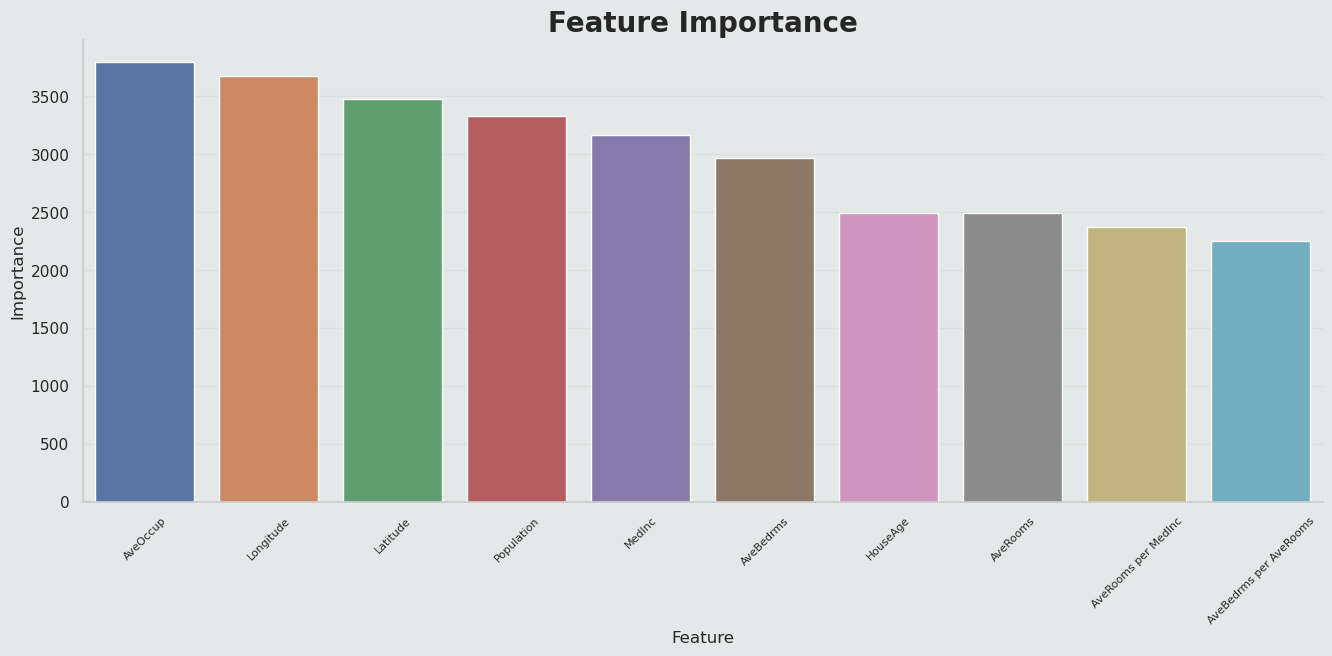

In [45]:
# Plot the feature importance
ax = sns.barplot(data=feature_importance_df, 
                 x='Feature', 
                 y='Importance')

# Set title
ax.set_title('Feature Importance', 
             fontsize=20, 
             fontweight='bold')

plt.xticks(fontsize=8, 
           rotation=45)

plt.show()

# Submission

In [46]:
# Generate predictions
submission_predictions = pipe_lgb.predict(test_data)

In [47]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data.index, 'MedHouseVal': submission_predictions})

In [48]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)